In [14]:
"""
Notebook: regresion.ipynb
Propósito: pipeline para armar FCFF por empresa, generar matrices de sensibilidad DCF,
construir data para regresiones (log-log) entre valor DCF, WACC y g, y graficar relaciones básicas.

Convenciones:
- wacc, g en términos decimales (0.10 = 10%).
- Perpetuidad creciente con g < wacc.
- Valor por acción: (EV - Net Debt)/Shares.
- En análisis de regresión se usan transformaciones logarítmicas (log-log).
"""

'\nNotebook: regresion.ipynb\nPropósito: pipeline para armar FCFF por empresa, generar matrices de sensibilidad DCF,\nconstruir data para regresiones (log-log) entre valor DCF, WACC y g, y graficar relaciones básicas.\n\nConvenciones:\n- wacc, g en términos decimales (0.10 = 10%).\n- Perpetuidad creciente con g < wacc.\n- Valor por acción: (EV - Net Debt)/Shares.\n- En análisis de regresión se usan transformaciones logarítmicas (log-log).\n'

In [15]:
# Clase simple para guardar parámetros por ticker (WACC y acciones)
class Accion():
    def __init__(self, wacc, shares):
        self.wacc = wacc       # WACC central de la empresa (decimal)
        self.shares = shares   # Acciones en circulación (millones)
  
# Diccionario con parámetros base por ticker (WACC y acciones)
acciones = {
    "AAPL": Accion(0.102, 15408),
    "AMZN": Accion(0.109, 10721),
    "AVGO": Accion(0.149, 4778),
    "GOOGL": Accion(0.101, 12447),
    "META": Accion(0.108, 2614),
    "MSFT": Accion(0.097, 7469),
    "NVDA": Accion(0.151, 24940),
    "TSLA": Accion(0.132, 3498),
    "ORCL": Accion(0.109, 2866),
    "WMT": Accion(0.083, 8081),
}

# Armado de lista con todos los tickers
lista_acciones = acciones.keys()

all_waccs = []

for ticker in lista_acciones:
    all_waccs.append(acciones[ticker].wacc)


In [16]:
import pandas as pd
import re
import numpy as np

info_all_acciones = []  # (Opcional) lista agregada de resultados por compañía

# Nota: en celdas siguientes se irán creando/llenando diccionarios como info_limpia, netdebts, etc.

for accion in lista_acciones:
    try:
        info_all_acciones.append(pd.read_excel(f"C:/Users/usuario/OneDrive/Python/python_for_finance/Excels/Est{accion}.xlsx")) # Notebook
    except:
        info_all_acciones.append(pd.read_excel(f"C:/Users/Adrian/OneDrive/Python/python_for_finance/Excels/Est{accion}.xlsx")) # PC

tickers = []
todos_los_excels_limpios = []

# Pipeline de limpieza de los excels con las funciones que se encuentran ya explicadas en funciones.py
def limpiar_excel(excel):
    """
    Toma el Excel crudo exportado desde Bloomberg y devuelve:
      - excel_limpio: DataFrame con años como columnas y cuentas como índice.
      - ticker: str detectado de la primera celda (asumido formato estándar).
    Pasos:
      1) Mueve la primera columna a índice (allí viene un header con ticker/etiquetas).
      2) Quita filas/columnas de encabezado redundante.
      3) Mantiene sólo columnas de años y estandariza nombres a 'YYYY'.
    """
    # La primera columna suele contener etiquetas; la mandamos a índice
    excel.index = excel.iloc[:,0]
    # Del mismo encabezado inferimos el ticker (primera "palabra" de la primera fila)
    ticker = excel.index[0].split()[0]
    # Eliminamos la primera columna (ya la usamos como índice)
    excel_limpio = excel.drop(excel.columns[0], axis=1)
    # Removemos fila de título adicional
    excel_limpio = excel_limpio.drop(excel_limpio.index[0])
    # La primera fila remanente contiene headers de columna → pasamos a headers reales
    excel_limpio.columns = excel_limpio.iloc[0]
    # Quitamos esa fila de headers que ya reasignamos
    excel_limpio = excel_limpio.drop(excel_limpio.index[0])
    # Eliminamos columnas no numéricas iniciales (metadatos típicos en exportes)
    excel_limpio = excel_limpio.drop(excel_limpio.iloc[:,0:3], axis=1)
    
    # Nos quedamos con los 4 primeros caracteres de cada header como año 'YYYY'
    anios = [anio[:4] for anio in list(excel_limpio.columns)]
    excel_limpio.columns = anios

    # Devolvemos DataFrame con cuentas en índice y años en columnas, y el ticker inferido    
    return [pd.DataFrame(excel_limpio), ticker]

def extraer_partidas(excel_limpio):
    """
    Filtra del DataFrame limpio las filas (cuentas) relevantes para FCFF:
    - Deuda (Total/Net/ST/LT), Cash/Equivalents, Tax Rate, Revenue, Operating Margin,
      Depreciation & Amortization, CAPEX, Current Assets/Liabilities.
    Usa un patrón regex robusto para capturar variantes de nomenclatura.
    Retorna 'partidas' como DataFrame float para facilitar cálculos posteriores.
    """
    # Lista de patrones (regex) que cubren nomenclaturas alternativas comunes en Bloomberg
    patterns = [
        r'^(?!.*\b(?:Re)?Payments\b).*(?:Total Debt$|Debt$|Net(?=.*\bdebt\b))', # Deuda Total / Neta
        r'Equivalents\s\w*\sShort|\bEquivalents\b.*\bMarketable\b|\bCash\b.*Marketable|\bCash\b.*Short-term|\bCash\b.*Equivalents$', # Caja y Equivalentes
        r'^\s*?Tax Rate\s\(\%\)', # Tasa Impositiva %
        r'^\s*?Revenue$|^\s*?Net Revenue', # Ventas
        r'^\s*Operating Margin\s\(\%\)', # Margen Operativo %
        r'(?:Depreciation\s*(?:&|and)\s*Amortization|D\s*&\s*A)', # D&A
        r'(?:Capital\s*Expenditures?$|CAPEX|Capex)', # CAPEX 
        r'^\s*Current Assets$', # Activo Corriente
        r'^\s*Current Liabilities$' # Pasico Corriente
    ]

    # Compilamos un patrón OR con flags case-insensitive
    pat = re.compile('|'.join(patterns), flags=re.IGNORECASE)

    # Creamos máscara booleana sobre el índice (nombres de cuentas)
    mask = excel_limpio.index.astype(str).str.contains(pat, regex=True, na=False)
    partidas = excel_limpio.loc[mask]

    # Normalizamos espacios
    partidas.index = partidas.index.str.strip()
    # Pasamos a float (las columnas son años); filas son cuentas
    partidas = partidas.astype(float)
    
    return partidas

def normalizar_indice(nombre):
    """
    Recibe un nombre de cuenta (string) y devuelve un alias estándar
    usado internamente en el pipeline (e.g., 'Revenue' → 'Ventas').
    Permite consolidar variantes de nombres provenientes del Excel.
    """
    nombre = nombre.strip().lower()

    # Mapeo de patrones → etiqueta estándar que usa el pipeline DCF
    patrones = {
        r"total(?=.*\bdebt\b)": "Total Debt",
        r"short(?=.*\bdebt\b)": "ST Debt",
        r"net(?=.*\bdebt\b)": "Net Debt",
        r"debt": "LT Debt",
        r"cash|marketable": "Cash",
        r"revenue": "Ventas",
        r"tax": 'Tax',
        r"margin": "Opmg",
        r"nopat": "NOPAT",
        r"depreciation.*amortization": "D&A",
        r"capex|capital expenditures?": "CAPEX",
        r"current assets": "Current Assets",
        r"current liabilities": "Current Liabilities"
    }

    # Buscamos el primer patrón que matchee y devolvemos la etiqueta definida
    for patron, nuevo in patrones.items():
        if re.search(patron, nombre, re.IGNORECASE):
            return nuevo
    
    # Si no encontramos patrón, devolvemos el nombre original (ya normalizado en casing)    
    return nombre  

def limpiar_partidas(partidas):
    """
    Post-procesa 'partidas' para:
      - Eliminar filas completamente nulas.
      - Rellenar NaN con 0 (evita interrupciones posteriores).
      - Quitar duplicadas y resolver colisiones (si hay multi-entradas por misma cuenta,
        conservar la fila con mayor suma como 'representativa').
    """
    # Quitamos filas totalmente vacías (todas las columnas NaN)
    partidas = partidas[~partidas.isnull().all(axis=1)] 
    # Relleno defensivo: NaN → 0. Evita errores en aritmética posterior.
    partidas = partidas.fillna(0)
    # Eliminamos duplicados exactos
    partidas = partidas.drop_duplicates()

    # En ocasiones puede quedar un índice duplicado con frames anidados
    cuentas = partidas.index

    # Resolución de conflictos: si por alguna razón loc[cuenta] devuelve DataFrame,
    # tomamos la fila con mayor suma (proxy simple de "entrada principal").
    for cuenta in cuentas:
        if type(partidas.loc[cuenta]) == pd.core.frame.DataFrame:
            operando = partidas.loc[cuenta]
            fila_max = operando[operando.sum(axis=1) == operando.sum(axis=1).max()]
            # Eliminamos las apariciones anteriores…
            partidas = partidas.drop(cuenta)
            # …y dejamos una sola fila con el nombre de la cuenta   
            partidas.loc[cuenta] = fila_max.loc[cuenta]
            
    return partidas

def completar_partidas(partidas):
    for cuenta in partidas.index:
        # Si hay algún 0 en la cuenta, estimamos por proporción a Ventas
        if partidas.loc[cuenta].eq(0).any():
            # Proporción cuenta/Ventas por columna (año)
            porcentaje = partidas.loc[cuenta] / partidas.loc['Ventas']
            # Promedio de proporciones excluyendo ceros (evita sesgo a la baja)
            porcentaje_medio = porcentaje[porcentaje != 0].mean()
            # Ubicamos en qué años la cuenta vale 0
            resultados = partidas.loc[cuenta][partidas.loc[cuenta] == 0]
            # Traemos las ventas de esos mismos años
            ventas = partidas.loc['Ventas', resultados.index]
            # Reemplazamos 0 por Ventas * proporción promedio
            partidas.loc[cuenta, partidas.loc[cuenta] == 0] = ventas * porcentaje_medio
            
    return partidas

def calcular_nuevas_partidas(partidas):
    """
    Completa el dataset financiero con partidas clave para FCFF:
      - WK (Working Capital operativo) = (Current Assets - Cash) - Current Liabilities
      - Change WK = Δ interanual del WK (uso .diff() por columnas)
      - NOPAT = Ventas * (Opmg %) * (1 - Tax %)
      - FCFF  = NOPAT + D&A + CAPEX - Change WK
    Nota: Por convención de este pipeline, CAPEX entra con su signo contable (suele ser negativo).
    """
    # Capital de trabajo operativo (excluye efectivo)
    partidas.loc['WK'] = (partidas.loc['Current Assets'] - partidas.loc['Cash']) - partidas.loc['Current Liabilities']
    # Variación interanual del WK (por columnas: años)
    partidas.loc['Change WK'] = partidas.loc['WK'].diff()
    # Beneficio operativo después de impuestos (Opmg y Tax vienen en %)
    partidas.loc['NOPAT'] = partidas.loc['Ventas'] * (partidas.loc['Opmg'] / 100) * (1-partidas.loc['Tax']/100)
    # FCFF no apalancado: suma D&A, agrega CAPEX (negativo si es inversión) y descuenta ΔWK
    partidas.loc['FCFF'] = partidas.loc['NOPAT'] + partidas.loc['D&A'] + partidas.loc['CAPEX'] - partidas.loc['Change WK']

    return partidas

# Lista de resguardo de los excels crudos
excels_sin_completar = []

# Limpieza de cada excel
for excel in info_all_acciones:
    excel_limpio = limpiar_excel(excel)[0]
    tickers.append(limpiar_excel(excel)[1])
    partidas = extraer_partidas(excel_limpio)
    
    partidas.index = partidas.index.map(normalizar_indice)
    partidas = partidas.astype(float)
    
    partidas_sin_completar = limpiar_partidas(partidas)
    
    excels_sin_completar.append(partidas_sin_completar.copy())
    
    partidas_completas = completar_partidas(partidas_sin_completar)
    partidas_completas = calcular_nuevas_partidas(partidas_completas)
    
    todos_los_excels_limpios.append(partidas_completas)

# Creación de diccionarios con la informacion de todas las compañías
info_sin_completar = {}
info_limpia = {}

informacion_limpia = list(zip(tickers, todos_los_excels_limpios))
info_sin_completar2 = list(zip(tickers, excels_sin_completar))

for ticker, info in informacion_limpia:
    info_limpia[ticker] = info

for ticker, info in info_sin_completar2:
    info_sin_completar[ticker] = info



In [17]:
# Obtención de la deuda neta para cada compañía y guardado en una lista
def get_netdebt(partidas):
    """
    Devuelve la Deuda Neta (Net Debt) usando prioridad:
      1) Si existe 'Net Debt', usarla.
      2) Si existe 'Total Debt' y 'Cash', Net = Total - Cash.
      3) Si existen 'ST Debt' + 'LT Debt' y 'Cash', Net = ST + LT - Cash.
      4) Caso mínimo: 'LT Debt' - 'Cash'.
    Se toma el primer año (columna 0) como referencia de deuda neta para el cálculo de equity.
    """
    # Caso ideal: viene reportada la Net Debt
    if 'Net Debt' in partidas.index:
        netdebt = float(partidas.loc['Net Debt', partidas.columns[0]])
        return netdebt
    # Siguiente mejor: Total Debt y Cash
    elif 'Total Debt' in partidas.index:
        netdebt = float(partidas.loc['Total Debt', partidas.columns[0]] - partidas.loc['Cash', partidas.columns[0]])
        return netdebt 
    # Alternativa: ST + LT - Cash
    elif 'ST Debt' in partidas.index and 'LT Debt' in partidas.index:
        netdebt = float(partidas.loc['ST Debt', partidas.columns[0]] + partidas.loc['LT Debt', partidas.columns[0]] - partidas.loc['Cash', partidas.columns[0]]) 
        return netdebt
    # Fallback mínimo
    else:
        netdebt = float(partidas.loc['LT Debt', partidas.columns[0]] - partidas.loc['Cash', partidas.columns[0]]) 
        return netdebt

# Diccionario que guarda las deudas netas como valores con los tickers correspondientes como claves
netdebts = {}

for ticker, info in info_sin_completar.items():    
    netdebts[ticker] = get_netdebt(info)

In [18]:
import pandas as pd

# Elección del año donde se establizan los flujos
def elegir_ultimo_fcff_estable(df, fila_fcff="FCFF", k_pos=4):
    """
    Devuelve:
      - anio_corte: año (columna) hasta el cual hay k_pos FCFF positivos consecutivos.
      - serie_fcff_cortada: serie FCFF hasta anio_corte inclusive.

    Lógica:
      - Revisa la fila 'FCFF' (como float).
      - Construye una racha de positivos (rolling) de largo k_pos.
      - Si existe alguna ventana completa de positivos, toma el último año de esa ventana como corte.
      - Si no hay 4 seguidos, usa el último FCFF positivo (si existe); si no hay ninguno, levanta error.
    """
    # Obtenemos la serie de FCFF (aseguramos dtype float)
    fcff = df.loc[fila_fcff].astype(float)  
    # Vector 1/0 de positivos
    positivos = (fcff > 0).astype(int)
    # Racha de positivos de largo k_pos    
    racha_pos = positivos.rolling(k_pos, min_periods=k_pos).sum() == k_pos
    # Máscara: FCFF>0 y racha completa
    mascara = (fcff > 0) & racha_pos 

    # Índices (años) candidatos donde la condición se cumple
    candidatos = mascara[mascara].index
    if len(candidatos) > 0:
        anio_corte = candidatos[-1]
    else:
        # Fallback: último año con FCFF>0
        pos = (fcff > 0)
        if pos.any():
            anio_corte = pos[pos].index[-1]
        else:
            # Sin FCFF positivos: no hay base para perpetuidad → revisar supuestos
            raise ValueError("No hay ningún FCFF positivo; revisá supuestos.")
        
    # Cortamos la serie hasta el año de corte
    serie_fcff_cortada = fcff.loc[:anio_corte]
    return anio_corte, serie_fcff_cortada

In [19]:
# Calculo y guardado de los FCFFs para cada empresa
free_cash_flows_empresas = {}

for ticker, partidas in info_limpia.items():
    anio_corte, fcff_hasta_corte = elegir_ultimo_fcff_estable(partidas)
    
    free_cash_flows = np.array(fcff_hasta_corte)[1:] 
    
    data = [anio_corte, free_cash_flows]
    
    free_cash_flows_empresas[ticker] = data[1]
    
free_cash_flows_datos = {}

for ticker, fcfs in free_cash_flows_empresas.items():
    free_cash_flows_datos[ticker] = fcfs
    

In [20]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt

# Funciones auxiliares tambien ya explicadas en funciones.py

def valuacion_DCF(wacc, g, free_cash_flows, ticker, netdebt):
    """
    Calcula el precio por acción vía FCFF:
      1) Descuenta cada FCFF al WACC.
      2) En el último año explícito agrega valor terminal (perpetuidad creciente con tasa g).
      3) Suma → Enterprise Value (EV); resta Net Debt → Equity Value.
      4) Divide por 'shares' informadas para el ticker → Precio por acción.
    Devuelve [stock_value, perpetuidad] donde el segundo
    elemento es la fracción de la perpetuidad sobre el total descontado (ratio, no %).

    Notas:
    - Se asume g < wacc para asegurar convergencia de la perpetuidad (criterio estándar DCF).
    - 'free_cash_flows' debe estar en el orden temporal correcto (t=1...n).
    - 'acciones[ticker].shares' debe ser consistente en unidades con el equity.
    """    
    # Acciones en circulación del ticker
    shares = acciones[ticker].shares

    # Acumulador de descuentos descontados (incluye flujos explícitos y luego la perpetuidad)
    ddcf = []

    # Recorremos flujos; el último índice recibe además la perpetuidad
    for año, cashflow in enumerate(free_cash_flows):
        if año != len(free_cash_flows)-1:
            # Descuento del flujo explícito (año+1 porque enumerate arranca en 0)
            descuento = cashflow / (1+wacc)**(año+1)
            ddcf.append(descuento)
        else:
            # Último flujo explícito
            descuento = cashflow / (1+wacc)**(año+1)
            # Valor terminal (perpetuidad creciente): FCFF_(n) * (1+g) / (WACC - g), traído a t=0    
            perpetuidad = (cashflow * (1+g)) / (((1+wacc)**(año+1)) * (wacc - g))
            # Agregamos ambos al vector de descuentos
            ddcf.append(descuento)
            ddcf.append(perpetuidad)

    # Relación (proporción) de la perpetuidad respecto del total descontado (insight de sensibilidad)
    perpetuidad = perpetuidad / sum(ddcf)    

    # Enterprise value: suma de flujos descontados
    enterprise_value = np.array(ddcf).sum()
    # Equity value: EV - Deuda Neta
    equity = enterprise_value - netdebt
    # Precio por acción
    stock_value = equity / shares
    
    return [stock_value, perpetuidad]

n = 200

def calcular_waccs(wacc_central, cambio=0.0001, n=n):
    """
    Array con cambios relativos en torno al WACC central: desde (1-n*cambio) hasta (1+n*cambio),
    equiespaciada (2n+1 puntos). Ej.: wacc=10%, cambio=1%, n=5 → 10%±5%.
    """
    wacc_array = wacc_central + (np.linspace(-n*cambio, n*cambio, 2*n + 1)) 
    return wacc_array

def calcular_gs(g_central=0.03, cambio=0.0001, n=n):
    """
    Array con cambios relativos para la tasa g: igual idea que calcular_waccs pero aplicada a g.
    Asegurar luego que g < WACC al usarla en perpetuidad.
    """
    g_array = g_central + (np.linspace(-n*cambio, n*cambio, 2*n + 1)) 
    return g_array

In [21]:
# Bloque donde se generan valores de WACC y g para posteriormente usar en la creación del dataframe
# con los datos para correr la regresión.

accion_y_waccscongs = {}

accion_y_gs = calcular_gs(g_central=0.03, cambio=0.0001, n=200)

for ticker in info_limpia.keys():
    waccs = calcular_waccs(acciones[ticker].wacc, cambio=0.0001, n=200)
    
    accion_y_waccscongs[ticker] = list(zip(waccs, accion_y_gs))
    

In [ ]:
import pandas as pd
import numpy as np

# Bloque donde se realizan las valuaciones. Se generan los 4010 escenarios a ser evaluados en la regresión

filas = []

filas2 = []

for ticker, waccg in accion_y_waccscongs.items():
    for w, g in waccg:
        resultado = valuacion_DCF(
            wacc=w,
            g=g,
            free_cash_flows=free_cash_flows_empresas[ticker],
            ticker=ticker,
            netdebt=netdebts[ticker]
        )[0]
        
        filas.append({
            'ticker': ticker,
            'log_wacc_usado': np.log(w),
            'log_g_usada': np.log(g),
            'log_resultado_dcf': np.log(resultado)        
        })
        
        filas2.append({
            'ticker': ticker,
            'wacc_usado': w,
            'g_usada': g,
            'resultado_dcf': resultado        
        })        

df = pd.DataFrame(filas)


,ticker,log_wacc_usado,log_g_usada,log_resultado_dcf
0,AAPL,-2.501036,-4.605170,4.648133
1,AAPL,-2.499817,-4.595220,4.647741
2,AAPL,-2.498600,-4.585368,4.647348
3,AAPL,-2.497384,-4.575611,4.646955
4,AAPL,-2.496170,-4.565949,4.646562
...,...,...,...,...
4005,WMT,-2.276917,-3.003764,4.696985
4006,WMT,-2.275943,-3.001750,4.696557
4007,WMT,-2.274970,-2.999740,4.696128
4008,WMT,-2.273998,-2.997734,4.695699


In [23]:
from statsmodels.formula.api import ols
from statsmodels.api import qqplot

# Bloque donde se corre la regresión lineal multiple log-log por Mínimos Cuadrados Ordinarios.
# Tambien se utilizan errores estándar robustos de White.

modelo = ols("log_resultado_dcf ~ log_wacc_usado + log_g_usada", data=df).fit(cov_type="HC0")

modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      log_resultado_dcf   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     740.7
Date:                Thu, 13 Nov 2025   Prob (F-statistic):          1.79e-274
Time:                        12:14:04   Log-Likelihood:                -4575.6
No. Observations:                4010   AIC:                             9157.
Df Residuals:                    4007   BIC:                             9176.
Df Model:                           2                                         
Covariance Type:                  HC0                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.8790      0.121     15.550      0.000       1.642       2.116
log_wacc_usado    -1.9433      0.051    -38.394      0.000      -2.043      -1.844
log_g_usada        0.3536      0.030     11.985      0.000       0.296       0.411
==============================================================================
Omnibus:                      960.518   Durbin-Watson:                   0.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              283.177
Skew:                           0.424   Prob(JB):                     3.23e-62
Kurtosis:                       2.012   Cond. No.                         50.5
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import pandas as pd

# Bloque donde se realiza el test de Variance Inflation Factor

# Seleccionar las variables explicativas
X = df[['log_wacc_usado', 'log_g_usada']]

# Agregar constante (intercepto)
X = sm.add_constant(X)

# Calcular VIF para cada variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


         Variable         VIF
0           const  120.234747
1  log_wacc_usado    1.317940
2     log_g_usada    1.317940


In [ ]:
# Bloque de código donde se arma un dataframe con información de una valuación conjunta de todas las empresas
# para crear un gráfico ilustrativo de la relación del valor intrínseco con el WACC y con la g.

def valuacion_DCF_all(wacc, g, free_cash_flows, shares, netdebt):
    
    ddcf = []

    for año, cashflow in enumerate(free_cash_flows):
        if año != len(free_cash_flows)-1:
            descuento = cashflow / (1+wacc)**(año+1)
            ddcf.append(descuento)
        else:
            descuento = cashflow / (1+wacc)**(año+1)
            perpetuidad = (cashflow * (1+g)) / (((1+wacc)**(año+1)) * (wacc - g))
            ddcf.append(descuento)
            ddcf.append(perpetuidad)    
            
    enterprise_value = np.array(ddcf).sum()

    equity = enterprise_value - netdebt

    stock_value = equity / shares
    
    terminal_value = ddcf[-1] / sum(ddcf)
    
    return [stock_value, terminal_value]

fcf_all_empresas = sum(free_cash_flows_empresas.values())

netdebt_all = sum(netdebts.values())

all_shares = 0

for ticker in lista_acciones:
    all_shares += acciones[ticker].shares
    
waccs = calcular_waccs(0.10, cambio=0.001, n=500)

gs = calcular_gs(0.03, cambio=0, n=500)


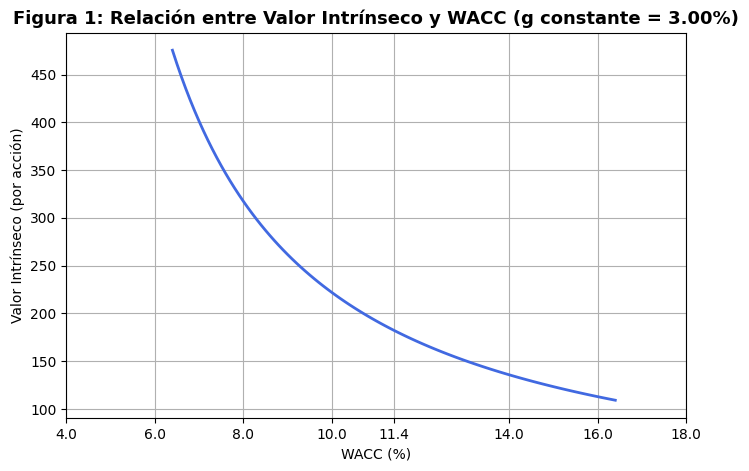

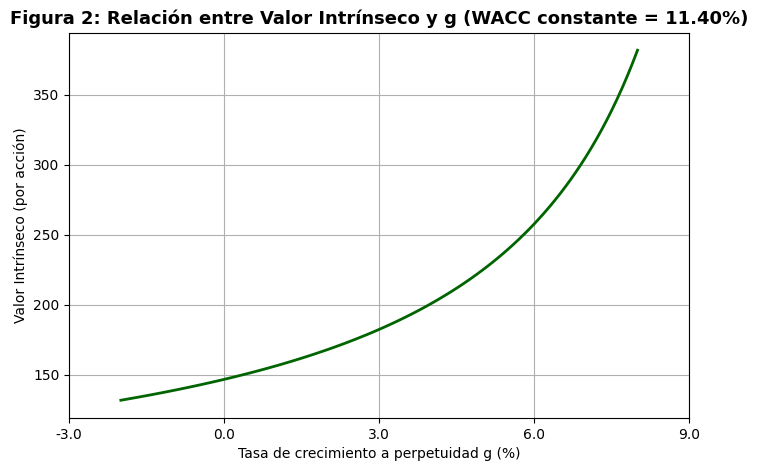

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Bloque que crea los gráficos ilustrativos de las relaciones entre el valor y WACC y g

# --- Parámetros base (puedes adaptarlos según tu caso) ---
free_cash_flows = fcf_all_empresas
netdebt = netdebt_all
 # objeto mínimo para simular .shares

wacc_central = 0.114
g_central = 0.03
n = 50
delta = 0.002  # paso 20 bps

# --- Construcción de arrays de WACC y g ---
wacc_array = calcular_waccs(0.114, cambio=0.001, n=n)
g_array = calcular_gs(0.03, cambio=0.001, n=n)

# --- Resultados DCF vs WACC (g constante) ---
dcf_vs_wacc = []
for w in wacc_array:
    val, _ = valuacion_DCF_all(w, g_central, free_cash_flows, shares=all_shares, netdebt=netdebt)
    dcf_vs_wacc.append(val)

# --- Resultados DCF vs g (WACC constante) ---
dcf_vs_g = []
for g in g_array:
    val, _ = valuacion_DCF_all(wacc_central, g, free_cash_flows, shares=all_shares, netdebt=netdebt)
    dcf_vs_g.append(val)

# --- Gráfico 1: DCF vs WACC ---
plt.figure(figsize=(8,5))
plt.plot(wacc_array * 100, dcf_vs_wacc, color='royalblue', linewidth=2)
plt.title(f"Figura 1: Relación entre Valor Intrínseco y WACC (g constante = {g_central:.2%})", fontweight='bold', fontsize=13)
plt.xlabel("WACC (%)")
plt.ylabel("Valor Intrínseco (por acción)")
plt.grid(True)

# Agregar una marca en el 11.4%
# Definir las marcas del eje x manualmente, incluyendo el 11.4
ticks = [4, 6, 8, 10, 11.4, 14, 16, 18]
plt.xticks(ticks, [f"{t:.1f}" for t in ticks])  # formato limpio con un decimal

plt.show()

# --- Gráfico 2: DCF vs g ---
plt.figure(figsize=(8,5))
plt.plot(g_array * 100, dcf_vs_g, color='darkgreen', linewidth=2)
plt.title(f"Figura 2: Relación entre Valor Intrínseco y g (WACC constante = {wacc_central:.2%})", fontweight='bold', fontsize=13)
plt.xlabel("Tasa de crecimiento a perpetuidad g (%)")
plt.ylabel("Valor Intrínseco (por acción)")
plt.grid(True)

# Definir las marcas del eje x manualmente, incluyendo el 11.4
ticks = [-3, 0, 3, 6, 9]
plt.xticks(ticks, [f"{t:.1f}" for t in ticks])  # formato limpio con un decimal

plt.show()
